# MrVI Quick Start Tutorial

MrVI (Multi-resolution Variational Inference) is a model for analyzing multi-sample single-cell RNA-seq data. This tutorial will guide you through the main features of MrVI.
MrVI is particularly suited for single-cell RNA sequencing datasets with comparable observations across many samples. By comparable, we mean observations derived from the same tissue or from the same cell line. This ensures that MrVI can provide accurate, single-cell-resolution estimates.


In [1]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

/usr/local/lib/python3.12/site-packages/scvi_colab/_core.py:41: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


In [1]:
import os
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scvi
import seaborn as sns
from scvi.external import MRVI

scvi.settings.seed = 0  # optional: ensures reproducibility
print("Last run with scvi-tools version:", scvi.__version__)
save_dir = tempfile.TemporaryDirectory()

/home/access/.conda/envs/scvi/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing CSCDataset from `anndata.experimental` is deprecated. Import anndata.abc.CSCDataset instead.
  warnings.warn(msg, FutureWarning)
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing CSRD

Last run with scvi-tools version: 1.2.1


# Preprocessing and model fitting

For this tutorial, we will use a subset of the COVID-19 single-cell RNA dataset from Stephenson et al. 2021 (Nature Medicine, https://doi.org/10.1038/s41591-021-01329-2) for the purpose of demonstrating the functionality of MrVI.
Specifically, this subset includes PBMCs from 16 donors in the Newcastle cohort (one of the sites comprising the dataset), randomly subsetted to 30,000 cells.

In [2]:
adata_path = os.path.join(save_dir.name, "haniffa_tutorial_subset.h5ad")

adata = sc.read(adata_path, backup_url="https://figshare.com/ndownloader/files/46017615")
sc.pp.highly_variable_genes(
    adata, n_top_genes=10000, inplace=True, subset=True, flavor="seurat_v3"
)
adata

  0%|          | 0.00/294M [00:00<?, ?B/s]

AnnData object with n_obs × n_vars = 30000 × 10000
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'age_int'
    var: 'feature_types', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg'

Before training, we need to specify which covariates in `obs` should be used as target (`sample_key`) and nuisance variables (`batch_key`). 
In this tutorial, we will use donor IDs (`patient_id`) as the target variable, and leave the batch variable empty since the data is already subsetted to the Newcastle cohort (denoted in `Site`).

Otherwise, we will focus on the following `obs` keys for the analysis:
- `initial_clustering`: coarse cell-type annotations from the original study.
- `Status`: whether the donor had COVID-19 or was healthy.
- `Days_from_onset`: how many days it had been since the onset of symptoms before the sample was taken.

In [3]:
sample_key = "patient_id"  # target covariate
# batch_key="Site"  # nuisance variable identifier
MRVI.setup_anndata(adata, sample_key=sample_key)

In [4]:
model = MRVI(adata)
model.train(max_epochs=400)

INFO     Jax module moved to cuda:0.Note: Pytorch lightning will show GPU is not being used for the Trainer.       


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

/home/access/.conda/envs/scvi/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:368: You have overridden `transfer_batch_to_device` in `LightningModule` but have passed in a `LightningDataModule`. It will use the implementation from `LightningModule` instance.
`Trainer.fit` stopped: `max_epochs=400` reached.


`Trainer.fit` stopped: `max_epochs=400` reached.


Once trained, we can plot the ELBO of the model to check if the model has converged.

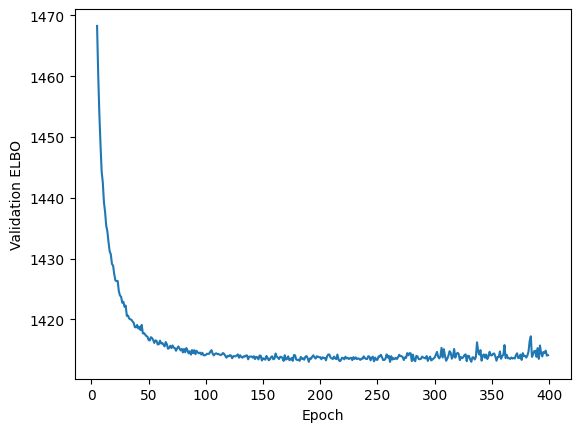

In [5]:
plt.plot(model.history["elbo_validation"].iloc[5:])
plt.xlabel("Epoch")
plt.ylabel("Validation ELBO")
plt.show()

# Visualize cell embeddings and sample distances

The latent representations of the cells can also be accessed and visualized using the `get_latent_representation` method.
MrVI learns two latent representations: `u` and `z`. `u` is designed to capture broad cell states invariant to sample and nuisance covariates, while `z` augments `u` with sample-specific effects but remains corrected for nuisance covariate effects.

In [6]:
u = model.get_latent_representation()
adata.obsm["u"] = u
sc.pp.neighbors(adata, use_rep="u")
sc.tl.umap(adata, min_dist=0.3)

100%|████████████████████████████████████████████████████████████████████████| 235/235 [00:02<00:00, 110.69it/s]


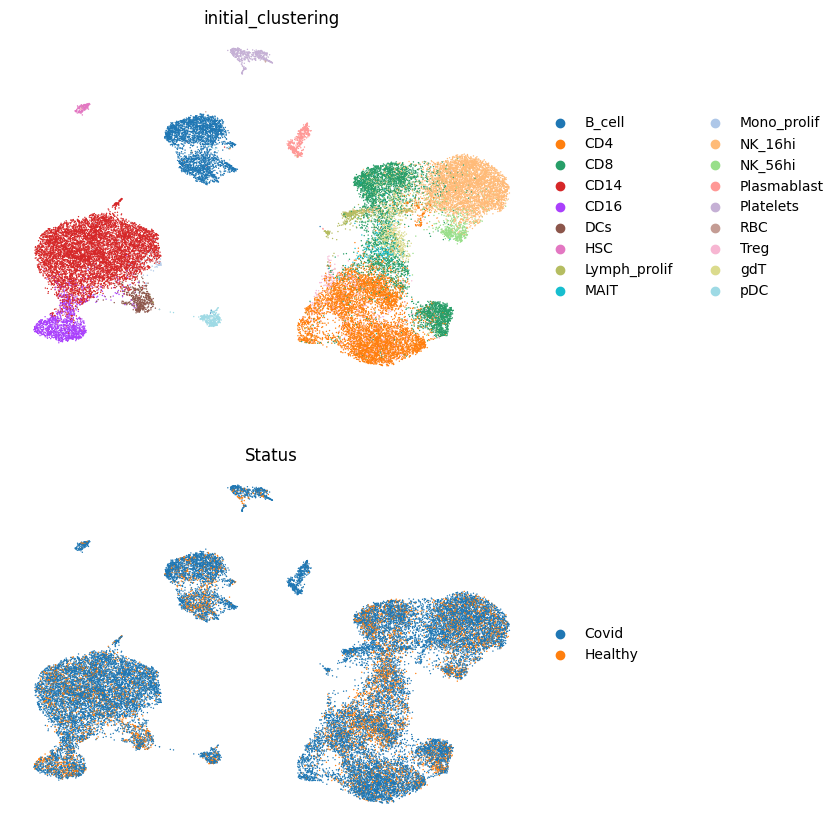

In [7]:
sc.pl.umap(
    adata,
    color=["initial_clustering", "Status"],
    frameon=False,
    ncols=1,
)

Sample distances can be computed using the `get_local_sample_distances` method, which characterizes sample relationships for any cell in the dataset.
This method can return cell-specific distances (`keep_cell=True`), as well as averaged distances within cell subpopulations, characterized by the `groupby` argument.
Specifying `keep_cell=False` will ensure that cell-specific distances are not returned, which can reduce the memory footprint of the returned object in the case where many samples are present.

In [8]:
dists = model.get_local_sample_distances(
    keep_cell=False, groupby="initial_clustering", batch_size=32
)
d1 = dists.loc[{"initial_clustering_name": "CD16"}].initial_clustering

100%|█████████████████████████████████████████████████████████████████████████| 938/938 [00:49<00:00, 18.95it/s]


  0%|          | 2/938 [00:01<10:17,  1.52it/s]

  0%|          | 4/938 [00:01<04:50,  3.22it/s]

  1%|          | 6/938 [00:01<03:17,  4.73it/s]

  1%|          | 7/938 [00:02<03:04,  5.05it/s]

  1%|          | 9/938 [00:02<02:26,  6.33it/s]

  1%|▏         | 12/938 [00:02<01:37,  9.50it/s]

  2%|▏         | 15/938 [00:02<01:15, 12.25it/s]

  2%|▏         | 17/938 [00:02<01:07, 13.69it/s]

  2%|▏         | 20/938 [00:02<00:58, 15.69it/s]

  2%|▏         | 22/938 [00:03<01:07, 13.53it/s]

  3%|▎         | 24/938 [00:03<01:02, 14.74it/s]

  3%|▎         | 27/938 [00:03<00:54, 16.59it/s]

  3%|▎         | 30/938 [00:03<00:51, 17.77it/s]

  4%|▎         | 33/938 [00:03<00:48, 18.67it/s]

  4%|▎         | 35/938 [00:03<00:47, 18.85it/s]

  4%|▍         | 38/938 [00:03<00:46, 19.35it/s]

  4%|▍         | 41/938 [00:03<00:45, 19.73it/s]

  5%|▍         | 44/938 [00:04<00:43, 20.39it/s]

  5%|▌         | 47/938 [00:04<00:54, 16.38it/s]

  5%|▌         | 50/938 [00:04<00:50, 17.66it/s]

  6%|▌         | 52/938 [00:04<00:48, 18.13it/s]

  6%|▌         | 54/938 [00:04<00:47, 18.45it/s]

  6%|▌         | 57/938 [00:04<00:45, 19.20it/s]

  6%|▋         | 60/938 [00:04<00:43, 20.03it/s]

  7%|▋         | 63/938 [00:05<00:42, 20.49it/s]

  7%|▋         | 66/938 [00:05<00:43, 20.25it/s]

  7%|▋         | 69/938 [00:05<00:42, 20.32it/s]

  8%|▊         | 72/938 [00:05<00:42, 20.46it/s]

  8%|▊         | 75/938 [00:05<00:41, 20.88it/s]

  8%|▊         | 78/938 [00:05<00:41, 20.54it/s]

  9%|▊         | 81/938 [00:06<00:41, 20.52it/s]

  9%|▉         | 84/938 [00:06<00:41, 20.75it/s]

  9%|▉         | 87/938 [00:06<00:41, 20.60it/s]

 10%|▉         | 90/938 [00:06<00:40, 20.87it/s]

 10%|▉         | 93/938 [00:06<00:40, 21.12it/s]

 10%|█         | 96/938 [00:06<00:40, 21.01it/s]

 11%|█         | 99/938 [00:06<00:40, 20.85it/s]

 11%|█         | 102/938 [00:07<00:39, 21.04it/s]

 11%|█         | 105/938 [00:07<00:40, 20.79it/s]

 12%|█▏        | 108/938 [00:07<00:39, 21.01it/s]

 12%|█▏        | 111/938 [00:07<00:47, 17.23it/s]

 12%|█▏        | 114/938 [00:07<00:45, 18.23it/s]

 12%|█▏        | 117/938 [00:07<00:43, 18.86it/s]

 13%|█▎        | 120/938 [00:07<00:41, 19.51it/s]

 13%|█▎        | 123/938 [00:08<00:41, 19.88it/s]

 13%|█▎        | 126/938 [00:08<00:47, 16.94it/s]

 14%|█▍        | 129/938 [00:08<00:45, 17.85it/s]

 14%|█▍        | 132/938 [00:08<00:42, 18.86it/s]

 14%|█▍        | 135/938 [00:08<00:41, 19.28it/s]

 15%|█▍        | 138/938 [00:08<00:40, 19.79it/s]

 15%|█▌        | 141/938 [00:09<00:40, 19.66it/s]

 15%|█▌        | 144/938 [00:09<00:39, 20.22it/s]

 16%|█▌        | 147/938 [00:09<00:38, 20.49it/s]

 16%|█▌        | 150/938 [00:09<00:38, 20.44it/s]

 16%|█▋        | 153/938 [00:09<00:37, 20.67it/s]

 17%|█▋        | 156/938 [00:09<00:37, 20.64it/s]

 17%|█▋        | 159/938 [00:09<00:37, 20.59it/s]

 17%|█▋        | 162/938 [00:10<00:37, 20.88it/s]

 18%|█▊        | 165/938 [00:10<00:36, 21.01it/s]

 18%|█▊        | 168/938 [00:10<00:36, 21.24it/s]

 18%|█▊        | 171/938 [00:10<00:36, 21.17it/s]

 19%|█▊        | 174/938 [00:10<00:35, 21.39it/s]

 19%|█▉        | 177/938 [00:10<00:35, 21.27it/s]

 19%|█▉        | 180/938 [00:10<00:34, 21.68it/s]

 20%|█▉        | 183/938 [00:11<00:35, 21.44it/s]

 20%|█▉        | 186/938 [00:11<00:35, 21.06it/s]

 20%|██        | 189/938 [00:11<00:35, 21.15it/s]

 20%|██        | 192/938 [00:11<00:35, 21.13it/s]

 21%|██        | 195/938 [00:11<00:35, 20.84it/s]

 21%|██        | 198/938 [00:11<00:35, 20.72it/s]

 21%|██▏       | 201/938 [00:11<00:35, 20.86it/s]

 22%|██▏       | 204/938 [00:12<00:35, 20.81it/s]

 22%|██▏       | 207/938 [00:12<00:34, 20.93it/s]

 22%|██▏       | 210/938 [00:12<00:34, 20.85it/s]

 23%|██▎       | 213/938 [00:12<00:34, 20.83it/s]

 23%|██▎       | 216/938 [00:12<00:34, 20.89it/s]

 23%|██▎       | 219/938 [00:12<00:34, 20.99it/s]

 24%|██▎       | 222/938 [00:12<00:34, 20.75it/s]

 24%|██▍       | 225/938 [00:13<00:34, 20.79it/s]

 24%|██▍       | 228/938 [00:13<00:34, 20.77it/s]

 25%|██▍       | 231/938 [00:13<00:33, 20.83it/s]

 25%|██▍       | 234/938 [00:13<00:33, 20.77it/s]

 25%|██▌       | 237/938 [00:13<00:33, 21.02it/s]

 26%|██▌       | 240/938 [00:13<00:33, 20.93it/s]

 26%|██▌       | 243/938 [00:13<00:33, 20.85it/s]

 26%|██▌       | 246/938 [00:14<00:33, 20.68it/s]

 27%|██▋       | 249/938 [00:14<00:32, 20.92it/s]

 27%|██▋       | 252/938 [00:14<00:32, 20.96it/s]

 27%|██▋       | 255/938 [00:14<00:32, 20.79it/s]

 28%|██▊       | 258/938 [00:14<00:32, 20.66it/s]

 28%|██▊       | 261/938 [00:14<00:32, 20.80it/s]

 28%|██▊       | 264/938 [00:14<00:32, 21.01it/s]

 28%|██▊       | 267/938 [00:15<00:32, 20.95it/s]

 29%|██▉       | 270/938 [00:15<00:31, 21.04it/s]

 29%|██▉       | 273/938 [00:15<00:31, 21.17it/s]

 29%|██▉       | 276/938 [00:15<00:31, 21.03it/s]

 30%|██▉       | 279/938 [00:15<00:31, 21.22it/s]

 30%|███       | 282/938 [00:15<00:30, 21.21it/s]

 30%|███       | 285/938 [00:15<00:31, 20.95it/s]

 31%|███       | 288/938 [00:16<00:31, 20.51it/s]

 31%|███       | 291/938 [00:16<00:31, 20.62it/s]

 31%|███▏      | 294/938 [00:16<00:31, 20.71it/s]

 32%|███▏      | 297/938 [00:16<00:30, 20.86it/s]

 32%|███▏      | 300/938 [00:16<00:30, 20.78it/s]

 32%|███▏      | 303/938 [00:16<00:30, 20.51it/s]

 33%|███▎      | 306/938 [00:16<00:30, 20.66it/s]

 33%|███▎      | 309/938 [00:17<00:30, 20.63it/s]

 33%|███▎      | 312/938 [00:17<00:30, 20.84it/s]

 34%|███▎      | 315/938 [00:17<00:29, 21.07it/s]

 34%|███▍      | 318/938 [00:17<00:29, 21.16it/s]

 34%|███▍      | 321/938 [00:17<00:29, 21.04it/s]

 35%|███▍      | 324/938 [00:17<00:29, 20.85it/s]

 35%|███▍      | 327/938 [00:17<00:29, 20.60it/s]

 35%|███▌      | 330/938 [00:18<00:29, 20.73it/s]

 36%|███▌      | 333/938 [00:18<00:29, 20.68it/s]

 36%|███▌      | 336/938 [00:18<00:29, 20.70it/s]

 36%|███▌      | 339/938 [00:18<00:28, 20.96it/s]

 36%|███▋      | 342/938 [00:18<00:28, 20.94it/s]

 37%|███▋      | 345/938 [00:18<00:28, 20.74it/s]

 37%|███▋      | 348/938 [00:18<00:28, 20.63it/s]

 37%|███▋      | 351/938 [00:19<00:28, 20.64it/s]

 38%|███▊      | 354/938 [00:19<00:28, 20.79it/s]

 38%|███▊      | 357/938 [00:19<00:28, 20.72it/s]

 38%|███▊      | 360/938 [00:19<00:27, 21.01it/s]

 39%|███▊      | 363/938 [00:19<00:27, 21.01it/s]

 39%|███▉      | 366/938 [00:19<00:27, 21.16it/s]

 39%|███▉      | 369/938 [00:19<00:26, 21.37it/s]

 40%|███▉      | 372/938 [00:20<00:26, 21.48it/s]

 40%|███▉      | 375/938 [00:20<00:26, 21.10it/s]

 40%|████      | 378/938 [00:20<00:26, 21.01it/s]

 41%|████      | 381/938 [00:20<00:26, 21.21it/s]

 41%|████      | 384/938 [00:20<00:26, 21.07it/s]

 41%|████▏     | 387/938 [00:20<00:26, 20.72it/s]

 42%|████▏     | 390/938 [00:20<00:26, 20.68it/s]

 42%|████▏     | 393/938 [00:21<00:25, 21.00it/s]

 42%|████▏     | 396/938 [00:21<00:25, 20.97it/s]

 43%|████▎     | 399/938 [00:21<00:25, 20.97it/s]

 43%|████▎     | 402/938 [00:21<00:25, 21.02it/s]

 43%|████▎     | 405/938 [00:21<00:25, 21.06it/s]

 43%|████▎     | 408/938 [00:21<00:24, 21.27it/s]

 44%|████▍     | 411/938 [00:21<00:25, 21.02it/s]

 44%|████▍     | 414/938 [00:22<00:24, 21.13it/s]

 44%|████▍     | 417/938 [00:22<00:25, 20.78it/s]

 45%|████▍     | 420/938 [00:22<00:24, 20.99it/s]

 45%|████▌     | 423/938 [00:22<00:24, 21.11it/s]

 45%|████▌     | 426/938 [00:22<00:24, 21.09it/s]

 46%|████▌     | 429/938 [00:22<00:24, 20.74it/s]

 46%|████▌     | 432/938 [00:22<00:24, 20.78it/s]

 46%|████▋     | 435/938 [00:23<00:24, 20.90it/s]

 47%|████▋     | 438/938 [00:23<00:24, 20.62it/s]

 47%|████▋     | 441/938 [00:23<00:24, 20.59it/s]

 47%|████▋     | 444/938 [00:23<00:23, 20.65it/s]

 48%|████▊     | 447/938 [00:23<00:23, 20.84it/s]

 48%|████▊     | 450/938 [00:23<00:23, 21.03it/s]

 48%|████▊     | 453/938 [00:23<00:23, 21.04it/s]

 49%|████▊     | 456/938 [00:24<00:22, 21.05it/s]

 49%|████▉     | 459/938 [00:24<00:22, 21.16it/s]

 49%|████▉     | 462/938 [00:24<00:22, 20.94it/s]

 50%|████▉     | 465/938 [00:24<00:22, 21.13it/s]

 50%|████▉     | 468/938 [00:24<00:22, 21.10it/s]

 50%|█████     | 471/938 [00:24<00:21, 21.26it/s]

 51%|█████     | 474/938 [00:24<00:21, 21.41it/s]

 51%|█████     | 477/938 [00:25<00:21, 21.28it/s]

 51%|█████     | 480/938 [00:25<00:21, 21.16it/s]

 51%|█████▏    | 483/938 [00:25<00:21, 21.26it/s]

 52%|█████▏    | 486/938 [00:25<00:21, 21.52it/s]

 52%|█████▏    | 489/938 [00:25<00:21, 21.31it/s]

 52%|█████▏    | 492/938 [00:25<00:21, 21.09it/s]

 53%|█████▎    | 495/938 [00:25<00:21, 20.98it/s]

 53%|█████▎    | 498/938 [00:26<00:21, 20.82it/s]

 53%|█████▎    | 501/938 [00:26<00:21, 20.57it/s]

 54%|█████▎    | 504/938 [00:26<00:20, 20.79it/s]

 54%|█████▍    | 507/938 [00:26<00:20, 21.08it/s]

 54%|█████▍    | 510/938 [00:26<00:20, 21.06it/s]

 55%|█████▍    | 513/938 [00:26<00:20, 20.97it/s]

 55%|█████▌    | 516/938 [00:26<00:20, 20.98it/s]

 55%|█████▌    | 519/938 [00:27<00:20, 20.86it/s]

 56%|█████▌    | 522/938 [00:27<00:19, 21.01it/s]

 56%|█████▌    | 525/938 [00:27<00:19, 20.98it/s]

 56%|█████▋    | 528/938 [00:27<00:20, 20.48it/s]

 57%|█████▋    | 531/938 [00:27<00:19, 20.53it/s]

 57%|█████▋    | 534/938 [00:27<00:19, 20.25it/s]

 57%|█████▋    | 537/938 [00:28<00:19, 20.27it/s]

 58%|█████▊    | 540/938 [00:28<00:19, 20.40it/s]

 58%|█████▊    | 543/938 [00:28<00:19, 20.43it/s]

 58%|█████▊    | 546/938 [00:28<00:18, 20.69it/s]

 59%|█████▊    | 549/938 [00:28<00:18, 20.66it/s]

 59%|█████▉    | 552/938 [00:28<00:18, 20.84it/s]

 59%|█████▉    | 555/938 [00:28<00:18, 21.03it/s]

 59%|█████▉    | 558/938 [00:29<00:18, 20.83it/s]

 60%|█████▉    | 561/938 [00:29<00:18, 20.72it/s]

 60%|██████    | 564/938 [00:29<00:17, 20.84it/s]

 60%|██████    | 567/938 [00:29<00:17, 20.84it/s]

 61%|██████    | 570/938 [00:29<00:17, 20.52it/s]

 61%|██████    | 573/938 [00:29<00:17, 20.70it/s]

 61%|██████▏   | 576/938 [00:29<00:17, 20.81it/s]

 62%|██████▏   | 579/938 [00:30<00:17, 20.94it/s]

 62%|██████▏   | 582/938 [00:30<00:17, 20.78it/s]

 62%|██████▏   | 585/938 [00:30<00:16, 20.96it/s]

 63%|██████▎   | 588/938 [00:30<00:16, 21.05it/s]

 63%|██████▎   | 591/938 [00:30<00:16, 20.88it/s]

 63%|██████▎   | 594/938 [00:30<00:16, 20.93it/s]

 64%|██████▎   | 597/938 [00:30<00:16, 21.09it/s]

 64%|██████▍   | 600/938 [00:31<00:16, 21.12it/s]

 64%|██████▍   | 603/938 [00:31<00:15, 21.16it/s]

 65%|██████▍   | 606/938 [00:31<00:15, 21.30it/s]

 65%|██████▍   | 609/938 [00:31<00:15, 20.88it/s]

 65%|██████▌   | 612/938 [00:31<00:15, 20.67it/s]

 66%|██████▌   | 615/938 [00:31<00:15, 21.05it/s]

 66%|██████▌   | 618/938 [00:31<00:15, 21.06it/s]

 66%|██████▌   | 621/938 [00:32<00:15, 20.85it/s]

 67%|██████▋   | 624/938 [00:32<00:15, 20.71it/s]

 67%|██████▋   | 627/938 [00:32<00:18, 17.19it/s]

 67%|██████▋   | 630/938 [00:32<00:16, 18.28it/s]

 67%|██████▋   | 632/938 [00:32<00:16, 18.49it/s]

 68%|██████▊   | 635/938 [00:32<00:15, 19.33it/s]

 68%|██████▊   | 638/938 [00:32<00:15, 19.58it/s]

 68%|██████▊   | 641/938 [00:33<00:14, 19.96it/s]

 69%|██████▊   | 644/938 [00:33<00:14, 20.15it/s]

 69%|██████▉   | 647/938 [00:33<00:14, 20.19it/s]

 69%|██████▉   | 650/938 [00:33<00:14, 20.32it/s]

 70%|██████▉   | 653/938 [00:33<00:13, 20.46it/s]

 70%|██████▉   | 656/938 [00:33<00:13, 20.81it/s]

 70%|███████   | 659/938 [00:33<00:13, 21.01it/s]

 71%|███████   | 662/938 [00:34<00:13, 20.95it/s]

 71%|███████   | 665/938 [00:34<00:13, 20.82it/s]

 71%|███████   | 668/938 [00:34<00:12, 20.81it/s]

 72%|███████▏  | 671/938 [00:34<00:12, 20.68it/s]

 72%|███████▏  | 674/938 [00:34<00:12, 20.59it/s]

 72%|███████▏  | 677/938 [00:34<00:12, 20.91it/s]

 72%|███████▏  | 680/938 [00:34<00:12, 20.82it/s]

 73%|███████▎  | 683/938 [00:35<00:12, 20.81it/s]

 73%|███████▎  | 686/938 [00:35<00:11, 21.23it/s]

 73%|███████▎  | 689/938 [00:35<00:11, 21.23it/s]

 74%|███████▍  | 692/938 [00:35<00:11, 21.35it/s]

 74%|███████▍  | 695/938 [00:35<00:11, 21.13it/s]

 74%|███████▍  | 698/938 [00:35<00:11, 20.75it/s]

 75%|███████▍  | 701/938 [00:35<00:11, 20.73it/s]

 75%|███████▌  | 704/938 [00:36<00:11, 20.27it/s]

 75%|███████▌  | 707/938 [00:36<00:11, 20.81it/s]

 76%|███████▌  | 710/938 [00:36<00:10, 20.88it/s]

 76%|███████▌  | 713/938 [00:36<00:10, 20.71it/s]

 76%|███████▋  | 716/938 [00:36<00:10, 20.63it/s]

 77%|███████▋  | 719/938 [00:36<00:10, 20.65it/s]

 77%|███████▋  | 722/938 [00:36<00:10, 21.04it/s]

 77%|███████▋  | 725/938 [00:37<00:10, 21.16it/s]

 78%|███████▊  | 728/938 [00:37<00:10, 20.93it/s]

 78%|███████▊  | 731/938 [00:37<00:09, 21.06it/s]

 78%|███████▊  | 734/938 [00:37<00:09, 20.75it/s]

 79%|███████▊  | 737/938 [00:37<00:09, 20.71it/s]

 79%|███████▉  | 740/938 [00:37<00:09, 20.65it/s]

 79%|███████▉  | 743/938 [00:37<00:09, 20.60it/s]

 80%|███████▉  | 746/938 [00:38<00:09, 20.20it/s]

 80%|███████▉  | 749/938 [00:38<00:09, 20.26it/s]

 80%|████████  | 752/938 [00:38<00:09, 20.42it/s]

 80%|████████  | 755/938 [00:38<00:08, 20.52it/s]

 81%|████████  | 758/938 [00:38<00:08, 20.59it/s]

 81%|████████  | 761/938 [00:38<00:08, 20.56it/s]

 81%|████████▏ | 764/938 [00:39<00:08, 20.69it/s]

 82%|████████▏ | 767/938 [00:39<00:08, 20.67it/s]

 82%|████████▏ | 770/938 [00:39<00:08, 20.75it/s]

 82%|████████▏ | 773/938 [00:39<00:07, 20.80it/s]

 83%|████████▎ | 776/938 [00:39<00:07, 20.71it/s]

 83%|████████▎ | 779/938 [00:39<00:07, 20.93it/s]

 83%|████████▎ | 782/938 [00:39<00:07, 20.96it/s]

 84%|████████▎ | 785/938 [00:40<00:07, 21.00it/s]

 84%|████████▍ | 788/938 [00:40<00:07, 20.75it/s]

 84%|████████▍ | 791/938 [00:40<00:07, 20.69it/s]

 85%|████████▍ | 794/938 [00:40<00:06, 20.79it/s]

 85%|████████▍ | 797/938 [00:40<00:06, 21.21it/s]

 85%|████████▌ | 800/938 [00:40<00:06, 21.09it/s]

 86%|████████▌ | 803/938 [00:40<00:06, 20.85it/s]

 86%|████████▌ | 806/938 [00:41<00:06, 20.68it/s]

 86%|████████▌ | 809/938 [00:41<00:06, 20.73it/s]

 87%|████████▋ | 812/938 [00:41<00:06, 20.66it/s]

 87%|████████▋ | 815/938 [00:41<00:06, 20.44it/s]

 87%|████████▋ | 818/938 [00:41<00:05, 20.72it/s]

 88%|████████▊ | 821/938 [00:41<00:05, 20.77it/s]

 88%|████████▊ | 824/938 [00:41<00:05, 20.83it/s]

 88%|████████▊ | 827/938 [00:42<00:05, 20.65it/s]

 88%|████████▊ | 830/938 [00:42<00:05, 20.67it/s]

 89%|████████▉ | 833/938 [00:42<00:05, 20.86it/s]

 89%|████████▉ | 836/938 [00:42<00:04, 20.77it/s]

 89%|████████▉ | 839/938 [00:42<00:04, 20.78it/s]

 90%|████████▉ | 842/938 [00:42<00:04, 20.96it/s]

 90%|█████████ | 845/938 [00:42<00:04, 20.77it/s]

 90%|█████████ | 848/938 [00:43<00:04, 20.92it/s]

 91%|█████████ | 851/938 [00:43<00:04, 20.79it/s]

 91%|█████████ | 854/938 [00:43<00:04, 20.97it/s]

 91%|█████████▏| 857/938 [00:43<00:03, 20.89it/s]

 92%|█████████▏| 860/938 [00:43<00:03, 20.64it/s]

 92%|█████████▏| 863/938 [00:43<00:03, 20.59it/s]

 92%|█████████▏| 866/938 [00:43<00:03, 20.31it/s]

 93%|█████████▎| 869/938 [00:44<00:03, 20.21it/s]

 93%|█████████▎| 872/938 [00:44<00:03, 20.57it/s]

 93%|█████████▎| 875/938 [00:44<00:03, 20.65it/s]

 94%|█████████▎| 878/938 [00:44<00:02, 20.57it/s]

 94%|█████████▍| 881/938 [00:44<00:02, 20.58it/s]

 94%|█████████▍| 884/938 [00:44<00:02, 20.68it/s]

 95%|█████████▍| 887/938 [00:44<00:02, 20.64it/s]

 95%|█████████▍| 890/938 [00:45<00:02, 20.91it/s]

 95%|█████████▌| 893/938 [00:45<00:02, 21.07it/s]

 96%|█████████▌| 896/938 [00:45<00:01, 21.20it/s]

 96%|█████████▌| 899/938 [00:45<00:01, 20.88it/s]

 96%|█████████▌| 902/938 [00:45<00:01, 20.97it/s]

 96%|█████████▋| 905/938 [00:45<00:01, 20.86it/s]

 97%|█████████▋| 908/938 [00:45<00:01, 20.74it/s]

 97%|█████████▋| 911/938 [00:46<00:01, 20.79it/s]

 97%|█████████▋| 914/938 [00:46<00:01, 21.11it/s]

 98%|█████████▊| 917/938 [00:46<00:00, 21.20it/s]

 98%|█████████▊| 920/938 [00:46<00:00, 21.04it/s]

 98%|█████████▊| 923/938 [00:46<00:00, 20.74it/s]

 99%|█████████▊| 926/938 [00:46<00:00, 21.16it/s]

 99%|█████████▉| 929/938 [00:46<00:00, 21.04it/s]

 99%|█████████▉| 932/938 [00:47<00:00, 21.22it/s]

100%|█████████▉| 935/938 [00:47<00:00, 21.33it/s]

100%|██████████| 938/938 [00:48<00:00,  6.35it/s]

100%|██████████| 938/938 [00:48<00:00, 19.36it/s]

The following cell provides useful utility functions to perform hierarchical clustering based on sample distances, as well as to extract sample metadata of interest to visualize the distance matrices

In [9]:
from matplotlib.colors import to_hex
from scipy.cluster.hierarchy import linkage, optimal_leaf_ordering
from scipy.spatial.distance import squareform


def get_sample_colors():
    cmap = sns.color_palette("viridis", as_cmap=True)

    def get_onset_colors(x):
        if x == "Healthy":
            return to_hex(np.array([0.5, 0.5, 0.5, 1.0]))
        else:
            x_ = int(x) / 30.0
            return to_hex(cmap(x_))

    covid_map = {
        "Covid": "red",
        "Healthy": "green",
    }
    sample_info = model.sample_info.set_index("sample_id")
    covid_colors = sample_info.Status.map(covid_map).values
    onset_colors = sample_info.Days_from_onset.map(get_onset_colors)
    colors = pd.DataFrame(
        {
            "covid": covid_colors,
            "onset": onset_colors,
        }
    )
    return colors


def get_dendrogram(dists):
    ds = squareform(dists)
    Z = linkage(ds, method="ward")
    Z = optimal_leaf_ordering(Z, ds)
    return Z

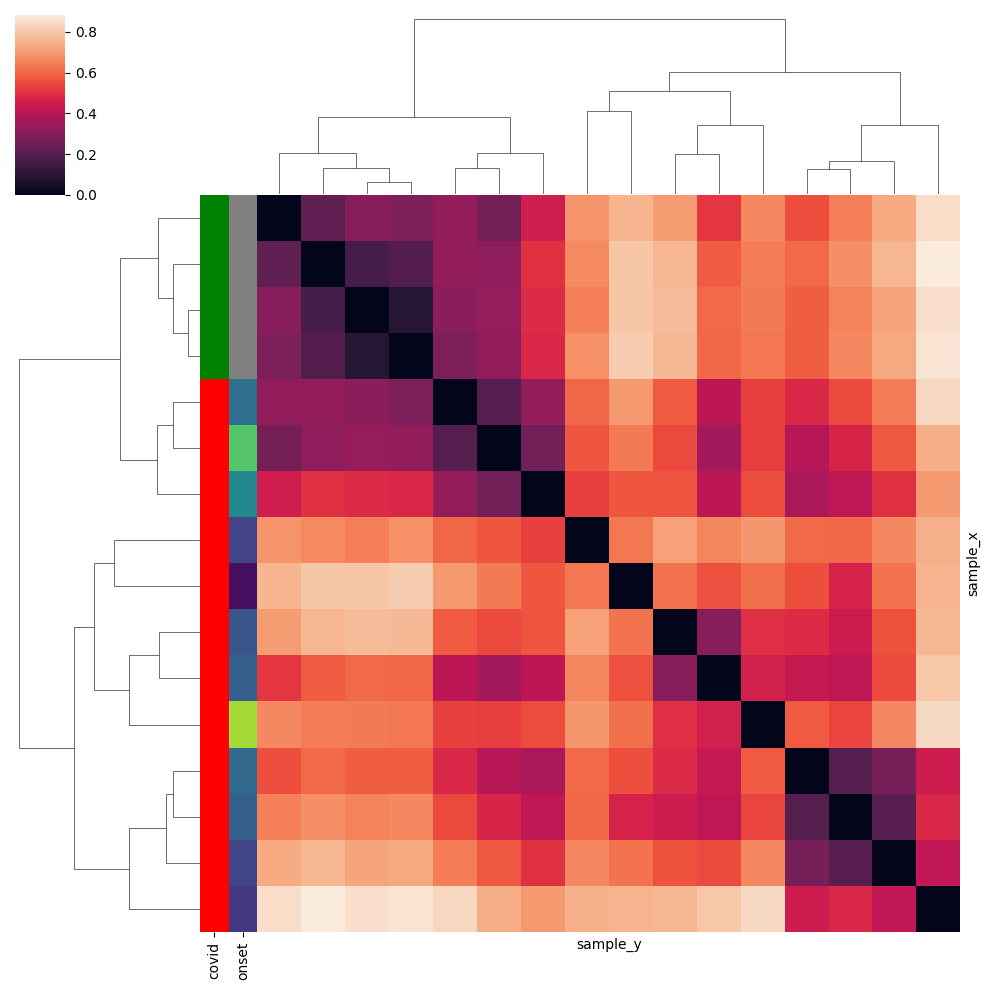

In [10]:
Z = get_dendrogram(d1)
colors = get_sample_colors()

sns.clustermap(
    d1.to_pandas(),
    row_linkage=Z,
    col_linkage=Z,
    xticklabels=False,
    yticklabels=False,
    row_colors=colors,
)

# Differential expression and differential abundance analysis

In this section of the tutorial, we will explore how to compute differential expression (DE) estimates that are linked to specific covariates of interest at the sample level. For a list of target covariates, MrVI will return covariate-specific effect sizes and p-values for each cell. This allows for a detailed analysis of how different covariates influence gene expression across different cell types. Additionally, you can visualize a summary of the overall effect size of a covariate, which helps in understanding the magnitude of the estimated latent effects of each covariate on the gene expression.

In [11]:
sample_cov_keys = ["Status"]  # Replace with your sample covariate of interest
model.sample_info["Status"] = model.sample_info["Status"].cat.reorder_categories(
    ["Healthy", "Covid"]
)  # Reorder categories such that the coefficient corresponds to Covid
de_res = model.differential_expression(
    sample_cov_keys=sample_cov_keys,
    store_lfc=True,
)

100%|█████████████████████████████████████████████████████████████████████████| 235/235 [00:13<00:00, 17.01it/s]


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 1/235 [00:01<07:04,  1.81s/it]

  2%|▏         | 4/235 [00:01<01:26,  2.67it/s]

  3%|▎         | 7/235 [00:02<00:44,  5.11it/s]

  4%|▍         | 10/235 [00:02<00:28,  7.77it/s]

  6%|▌         | 13/235 [00:02<00:21, 10.52it/s]

  7%|▋         | 16/235 [00:02<00:16, 13.16it/s]

  8%|▊         | 19/235 [00:02<00:13, 15.48it/s]

  9%|▉         | 22/235 [00:02<00:12, 17.53it/s]

 11%|█         | 25/235 [00:02<00:10, 19.22it/s]

 12%|█▏        | 28/235 [00:02<00:10, 20.55it/s]

 13%|█▎        | 31/235 [00:03<00:09, 21.58it/s]

 14%|█▍        | 34/235 [00:03<00:09, 22.32it/s]

 16%|█▌        | 37/235 [00:03<00:08, 22.90it/s]

 17%|█▋        | 40/235 [00:03<00:08, 23.28it/s]

 18%|█▊        | 43/235 [00:03<00:08, 23.55it/s]

 20%|█▉        | 46/235 [00:03<00:07, 23.83it/s]

 21%|██        | 49/235 [00:03<00:07, 23.87it/s]

 22%|██▏       | 52/235 [00:03<00:07, 23.99it/s]

 23%|██▎       | 55/235 [00:04<00:07, 24.11it/s]

 25%|██▍       | 58/235 [00:04<00:07, 24.12it/s]

 26%|██▌       | 61/235 [00:04<00:07, 24.23it/s]

 27%|██▋       | 64/235 [00:04<00:07, 24.24it/s]

 29%|██▊       | 67/235 [00:04<00:06, 24.25it/s]

 30%|██▉       | 70/235 [00:04<00:06, 24.23it/s]

 31%|███       | 73/235 [00:04<00:06, 24.19it/s]

 32%|███▏      | 76/235 [00:04<00:06, 24.19it/s]

 34%|███▎      | 79/235 [00:05<00:06, 24.16it/s]

 35%|███▍      | 82/235 [00:05<00:06, 24.22it/s]

 36%|███▌      | 85/235 [00:05<00:06, 24.28it/s]

 37%|███▋      | 88/235 [00:05<00:06, 24.23it/s]

 39%|███▊      | 91/235 [00:05<00:05, 24.24it/s]

 40%|████      | 94/235 [00:05<00:05, 24.23it/s]

 41%|████▏     | 97/235 [00:05<00:05, 24.29it/s]

 43%|████▎     | 100/235 [00:05<00:05, 24.28it/s]

 44%|████▍     | 103/235 [00:06<00:05, 24.30it/s]

 45%|████▌     | 106/235 [00:06<00:05, 24.37it/s]

 46%|████▋     | 109/235 [00:06<00:05, 24.40it/s]

 48%|████▊     | 112/235 [00:06<00:05, 24.32it/s]

 49%|████▉     | 115/235 [00:06<00:04, 24.34it/s]

 50%|█████     | 118/235 [00:06<00:04, 24.28it/s]

 51%|█████▏    | 121/235 [00:06<00:04, 24.20it/s]

 53%|█████▎    | 124/235 [00:06<00:04, 24.17it/s]

 54%|█████▍    | 127/235 [00:07<00:04, 24.18it/s]

 55%|█████▌    | 130/235 [00:07<00:04, 24.24it/s]

 57%|█████▋    | 133/235 [00:07<00:04, 24.25it/s]

 58%|█████▊    | 136/235 [00:07<00:04, 24.37it/s]

 59%|█████▉    | 139/235 [00:07<00:03, 24.43it/s]

 60%|██████    | 142/235 [00:07<00:03, 24.48it/s]

 62%|██████▏   | 145/235 [00:07<00:03, 24.44it/s]

 63%|██████▎   | 148/235 [00:07<00:03, 24.41it/s]

 64%|██████▍   | 151/235 [00:07<00:03, 24.34it/s]

 66%|██████▌   | 154/235 [00:08<00:03, 24.25it/s]

 67%|██████▋   | 157/235 [00:08<00:03, 24.27it/s]

 68%|██████▊   | 160/235 [00:08<00:03, 24.22it/s]

 69%|██████▉   | 163/235 [00:08<00:02, 24.23it/s]

 71%|███████   | 166/235 [00:08<00:02, 24.26it/s]

 72%|███████▏  | 169/235 [00:08<00:02, 24.26it/s]

 73%|███████▎  | 172/235 [00:08<00:02, 24.20it/s]

 74%|███████▍  | 175/235 [00:08<00:02, 24.13it/s]

 76%|███████▌  | 178/235 [00:09<00:02, 24.15it/s]

 77%|███████▋  | 181/235 [00:09<00:02, 24.25it/s]

 78%|███████▊  | 184/235 [00:09<00:02, 24.21it/s]

 80%|███████▉  | 187/235 [00:09<00:01, 24.28it/s]

 81%|████████  | 190/235 [00:09<00:01, 24.22it/s]

 82%|████████▏ | 193/235 [00:09<00:01, 24.09it/s]

 83%|████████▎ | 196/235 [00:09<00:01, 24.02it/s]

 85%|████████▍ | 199/235 [00:09<00:01, 24.04it/s]

 86%|████████▌ | 202/235 [00:10<00:01, 24.02it/s]

 87%|████████▋ | 205/235 [00:10<00:01, 24.08it/s]

 89%|████████▊ | 208/235 [00:10<00:01, 24.17it/s]

 90%|████████▉ | 211/235 [00:10<00:00, 24.13it/s]

 91%|█████████ | 214/235 [00:10<00:00, 24.25it/s]

 92%|█████████▏| 217/235 [00:10<00:00, 24.27it/s]

 94%|█████████▎| 220/235 [00:10<00:00, 24.27it/s]

 95%|█████████▍| 223/235 [00:10<00:00, 24.34it/s]

 96%|█████████▌| 226/235 [00:11<00:00, 24.42it/s]

 97%|█████████▋| 229/235 [00:11<00:00, 24.52it/s]

 99%|█████████▊| 232/235 [00:11<00:00, 24.55it/s]

100%|██████████| 235/235 [00:13<00:00,  5.04it/s]

100%|██████████| 235/235 [00:13<00:00, 18.04it/s]

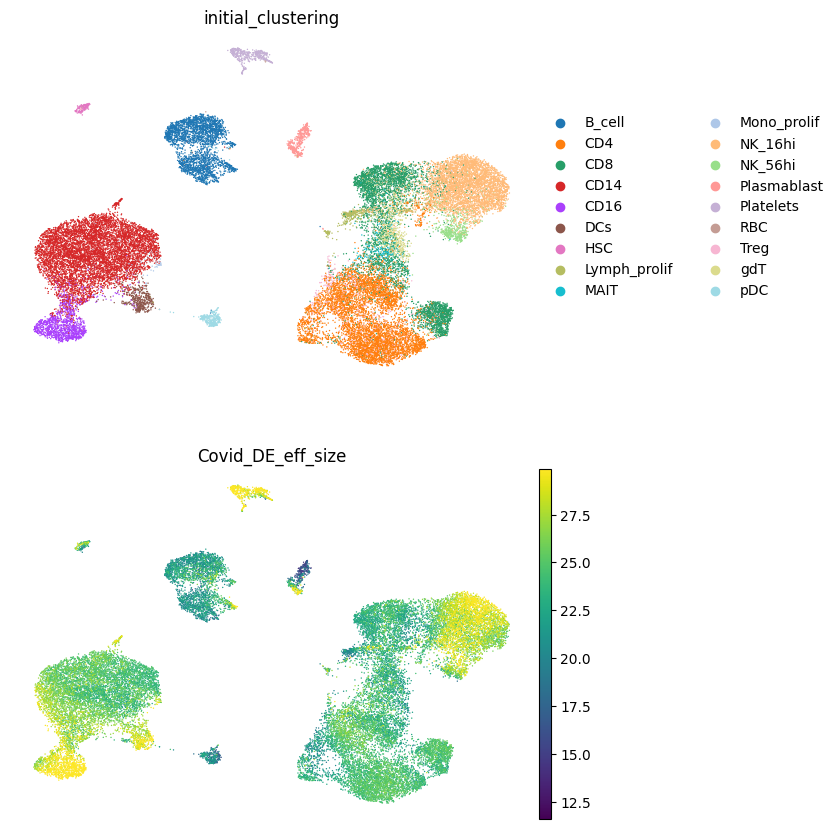

In [12]:
adata.obs["Covid_DE_eff_size"] = de_res.effect_size.sel(covariate="Status_Covid").values
sc.pl.umap(
    adata,
    color=["initial_clustering", "Covid_DE_eff_size"],
    frameon=False,
    ncols=1,
    vmax=np.quantile(de_res.effect_size.values, 0.95),
    cmap="viridis",
)

For the cell types with large effect sizes corresponding to the COVID status, we can look into which genes had the highest average LFCs.

<Figure size 1000x800 with 0 Axes>

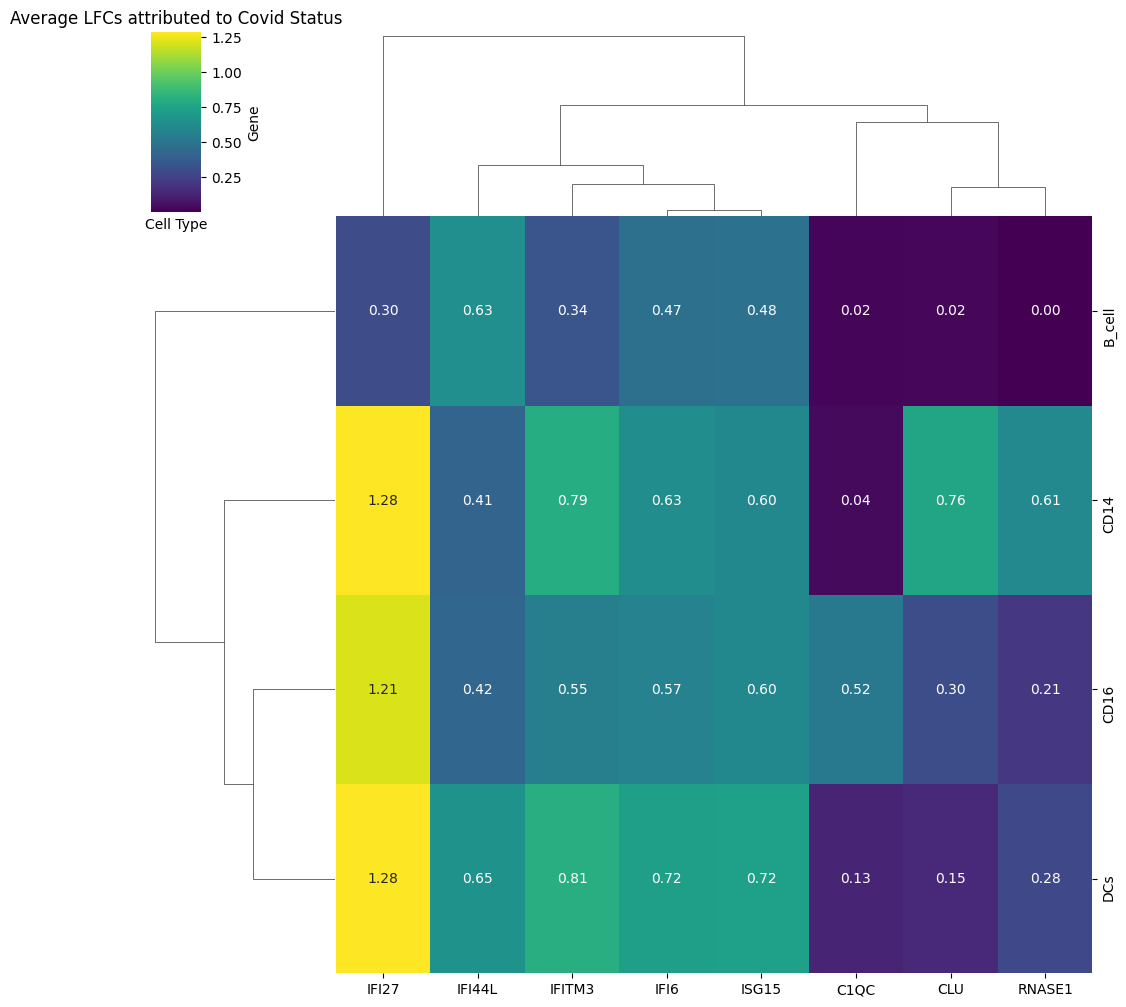

In [13]:
cell_types = ["CD16", "DCs", "CD14"]
top_genes_per_cell_type = {}

for cell_type in cell_types:
    cell_idxs = adata[(adata.obs["initial_clustering"] == cell_type)].obs.index
    top_genes = set(
        de_res.sel(cell_name=cell_idxs, covariate="Status_Covid")
        .mean(dim="cell_name")
        .lfc.to_pandas()
        .abs()
        .nlargest(5)
        .index
    )
    top_genes_per_cell_type[cell_type] = top_genes

all_top_genes = list(set.union(*top_genes_per_cell_type.values()))

# Add B Cells for comparison
cell_types.append("B_cell")

avg_lfcs = []
for cell_type in cell_types:
    cell_idxs = adata[(adata.obs["initial_clustering"] == cell_type)].obs.index
    avg_lfcs.append(
        de_res.sel(cell_name=cell_idxs, gene=all_top_genes).mean(dim="cell_name").lfc.values
    )

heatmap_data = pd.DataFrame(
    np.concatenate(avg_lfcs, axis=0), index=cell_types, columns=all_top_genes
)

plt.figure(figsize=(10, 8))
sns.clustermap(heatmap_data, annot=True, cmap="viridis", fmt=".2f")
plt.title("Average LFCs attributed to Covid Status")
plt.xlabel("Cell Type")
plt.ylabel("Gene")
plt.show()

Next, we will demonstrate how MrVI can be used to estimate local, covariate-linked differential abundance (DA) in single-cell data. Provided with sample-level target covariates, MrVI will return log likelihood values corresponding cell state abundance for each covariate. Differential abundance refers to the change in cellular composition correlated with target covariates, in this case, cellular composition defined over the `u` space.

In [14]:
da_res = model.differential_abundance(sample_cov_keys=sample_cov_keys)
covid_log_probs = da_res.Status_log_probs.loc[{"Status": "Covid"}]
healthy_log_probs = da_res.Status_log_probs.loc[{"Status": "Healthy"}]
covid_healthy_log_prob_ratio = covid_log_probs - healthy_log_probs

100%|███████████████████████████████████████████████████████████████████████████| 16/16 [00:33<00:00,  2.08s/it]


 13%|█▎        | 31/235 [00:00<00:02, 68.46it/s]

 26%|██▌       | 60/235 [00:00<00:01, 121.53it/s]

 38%|███▊      | 89/235 [00:00<00:00, 163.75it/s]

 50%|█████     | 118/235 [00:00<00:00, 197.28it/s]

 63%|██████▎   | 147/235 [00:01<00:00, 222.19it/s]

 75%|███████▍  | 176/235 [00:01<00:00, 240.52it/s]

 87%|████████▋ | 205/235 [00:01<00:00, 253.91it/s]

100%|█████████▉| 234/235 [00:01<00:00, 262.33it/s]

100%|██████████| 235/235 [00:01<00:00, 130.02it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:02<00:33,  2.20s/it]

 12%|█▎        | 2/16 [00:04<00:28,  2.06s/it]

 19%|█▉        | 3/16 [00:06<00:26,  2.04s/it]

 25%|██▌       | 4/16 [00:08<00:26,  2.18s/it]

 31%|███▏      | 5/16 [00:10<00:23,  2.09s/it]

 38%|███▊      | 6/16 [00:12<00:20,  2.05s/it]

 44%|████▍     | 7/16 [00:14<00:18,  2.02s/it]

 50%|█████     | 8/16 [00:16<00:16,  2.01s/it]

 56%|█████▋    | 9/16 [00:18<00:13,  1.99s/it]

 62%|██████▎   | 10/16 [00:20<00:11,  1.98s/it]

 69%|██████▉   | 11/16 [00:22<00:09,  1.98s/it]

 75%|███████▌  | 12/16 [00:24<00:07,  1.97s/it]

 81%|████████▏ | 13/16 [00:26<00:05,  1.90s/it]

 88%|████████▊ | 14/16 [00:27<00:03,  1.92s/it]

 94%|█████████▍| 15/16 [00:30<00:02,  2.07s/it]

100%|██████████| 16/16 [00:32<00:00,  1.98s/it]

100%|██████████| 16/16 [00:32<00:00,  2.01s/it]

We can take the difference between the log likelihood values to get a log likelihood ratio between two sample covariate groups.
In this case, a positive value corresponds to an enrichment of a certain cell state for donors with COVID.
We see that B cells, despite being low for DE attributed to COVID, are enriched in COVID patients.

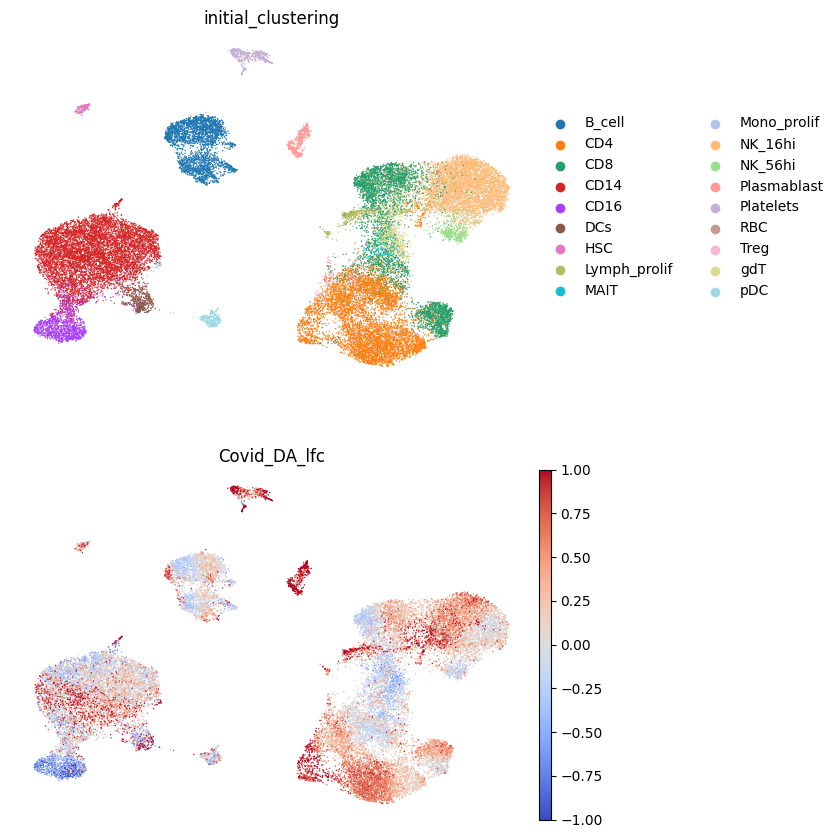

In [15]:
adata.obs["Covid_DA_lfc"] = covid_healthy_log_prob_ratio.values
sc.pl.umap(
    adata,
    color=["initial_clustering", "Covid_DA_lfc"],
    frameon=False,
    ncols=1,
    vmin=-1,
    vmax=1,
    cmap="coolwarm",
)